# Wake deficit model optimization
ChatGPT aided in som library and asset use.


In [1]:
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from py_wake.literature.gaussian_models import Bastankhah_PorteAgel_2014
from py_wake.literature.noj import Jensen_1983
from py_wake.superposition_models import LinearSum, SquaredSum
from swt6 import SWT6
from dudgeon import NAMES, WT_X, WT_Y
import numpy as np
import pandas as pd
from data_filter import prepare_turbine_seperated_data
from sklearn.model_selection import train_test_split


### Defining validation set


In [2]:

def get_ws_dataset(data):
    ws_df = None
    for name, df_i in data.items():
        df_i = df_i.rename(columns= {'WindSpeed': name})
        if name == 'A01':
            ws_df = df_i[name]
        else:
            ws_df = pd.merge(ws_df, df_i[name], on='timestamp', how='inner')
    ws_df = pd.merge(ws_df, data['A05']['WindDirection'], on='timestamp', how='inner')
    return ws_df

In [3]:
data = prepare_turbine_seperated_data()
ws_dataset = get_ws_dataset(data=data)
ws_dataset = ws_dataset[ws_dataset['WindDirection'] > 140]

### Reason for limited dataset

In [4]:
def print_missing_ws_values(data):
    ws_df = None
    for name, df_i in data.items():
        df_i = df_i.rename(columns= {'WindSpeed': name})
        if name == 'A01':
            ws_df = df_i[name]
        else:
            ws_df = pd.merge(ws_df, df_i[name], on='timestamp', how='outer')
    ws_df = pd.merge(ws_df, data['A05']['WindDirection'], on='timestamp', how='outer')
    print(ws_df.isna().sum())

print_missing_ws_values(data)

A01               254
A02                 9
A03              2109
A04               123
A05                 0
                 ... 
T02                87
T03              1114
T04                53
T05                 7
WindDirection       0
Length: 68, dtype: int64


### Showing wind directions

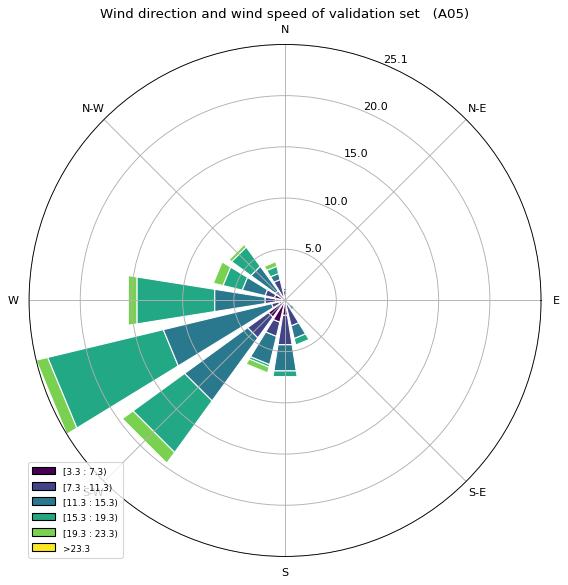

In [5]:
from windrose import WindroseAxes
import matplotlib.pyplot as plt

ax_wd = WindroseAxes.from_ax()
ax_wd.bar(ws_dataset['WindDirection'], ws_dataset['A05'], normed=True, opening=0.8, edgecolor='white')
ax_wd.set_legend()
ax_wd.set_title("Wind direction and wind speed of validation set   (A05)")
plt.show()

### Defining objective function

In [6]:
#sub_set1, sub_set2 = train_test_split(ws_dataset, test_size=0.5)  # Small subset held out for validation
sub_set1 = ws_dataset.sample(frac=1/3)
sub_set2 = ws_dataset.drop(sub_set1.index).sample(frac=1/2)
sub_set3 = ws_dataset.drop(sub_set1.index).drop(sub_set2.index)

In [7]:
from tqdm.notebook import tqdm
from wake_estimator import WakeEstimator
def get_mse(y_val, y_pred):
        mse = np.mean(np.square(y_val - y_pred))
        return mse

def objective_function(estimator: WakeEstimator, X_val, y_val):
    y_pred = []
    for x_i in X_val:
        y_pred_i = estimator.predict(x_i) #(ws, wd)
        y_pred.append(y_pred_i)
    y_pred = np.array(y_pred)
    return get_mse(y_val, y_pred)

def gridCV(X, y, param_grid):
    total = 1 
    for val in param_grid.values():
        total *= len(val)
    score_dict = {}

    with tqdm(total=total, desc=f'Testing Parameter Combinations') as pbar:
        for deficitModel in param_grid['deficitModel']:
            for superpositionModel in param_grid['superpositionModel']:
                for k in param_grid['k']:
                    estimator = WakeEstimator(deficitModel=deficitModel, superpositionModel=superpositionModel, k=k)
                    score_dict[(deficitModel.__name__, superpositionModel.__name__, k)] = objective_function(estimator=estimator, X_val=X, y_val=y)
                    pbar.update(1)

    return score_dict


### Defining the parameter grid

In [8]:
param_grid = {
    'deficitModel': [Jensen_1983, Bastankhah_PorteAgel_2014],
    'superpositionModel': [LinearSum, SquaredSum],
    'k': np.linspace(start=0.01, stop= 0.18, num=18)
}


In [9]:
ws_source_turbine = 'A05'

y_val_1 = sub_set1[NAMES].to_numpy()
y_val_2 = sub_set2[NAMES].to_numpy()
y_val_3 = sub_set3[NAMES].to_numpy()

x_val_1 = sub_set1[[ws_source_turbine, 'WindDirection']].to_numpy()
x_val_2 = sub_set2[[ws_source_turbine, 'WindDirection']].to_numpy()
x_val_3 = sub_set3[[ws_source_turbine, 'WindDirection']].to_numpy()

In [10]:
score_dict1 = gridCV(param_grid=param_grid, X=x_val_1, y=y_val_1)
score_dict2 = gridCV(param_grid=param_grid, X=x_val_2, y=y_val_2)
score_dict3 = gridCV(param_grid=param_grid, X=x_val_3, y=y_val_3)

Testing Parameter Combinations:   0%|          | 0/72 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
import seaborn as sns
#axes = plt.subplots(2, 3)
def plot_scores(deficit_model, superposition_model):
    values1, values2, values3 = [], [], []
    bar_width = 0.15

    for k in param_grid['k']:
        values1.append(score_dict1[(deficit_model, superposition_model, k)])
        values2.append(score_dict2[(deficit_model, superposition_model, k)])
        values3.append(score_dict3[(deficit_model, superposition_model, k)])
    index = np.arange(len(values1))
    bars1 = plt.bar(x=index, height=values1, width=bar_width, label='Subset 1')
    bars2 = plt.bar(x=index+bar_width, height=values2, width=bar_width, color='green', label='Subset 2')
    bars3 = plt.bar(x=index+bar_width*2, height=values3, width=bar_width, color='orange', label='Subset 3')
    
    plt.xlabel('$K_w$')
    plt.xticks(index + bar_width, param_grid['k'].round(3), rotation=90)
    plt.ylabel('MSE')  # Add y-axis label for clarity
    plt.title(f"K_w scores with '{deficit_model}' and '{superposition_model}'")  # Add a title for clarity
    for bar1, bar2, bar3 in zip(bars1, bars2, bars3):
        yvalue = (bar1.get_height() + bar2.get_height() + bar3.get_height())/3
        height = max([bar1.get_height() , bar2.get_height() , bar3.get_height()])
        plt.text(bar2.get_x() + bar2.get_width()/2.0, height, f'{round(yvalue, 2)}', ha='center', va='bottom')
    plt.legend()
    plt.tight_layout()

#sns.heatmap(ax=axes[0, 0])

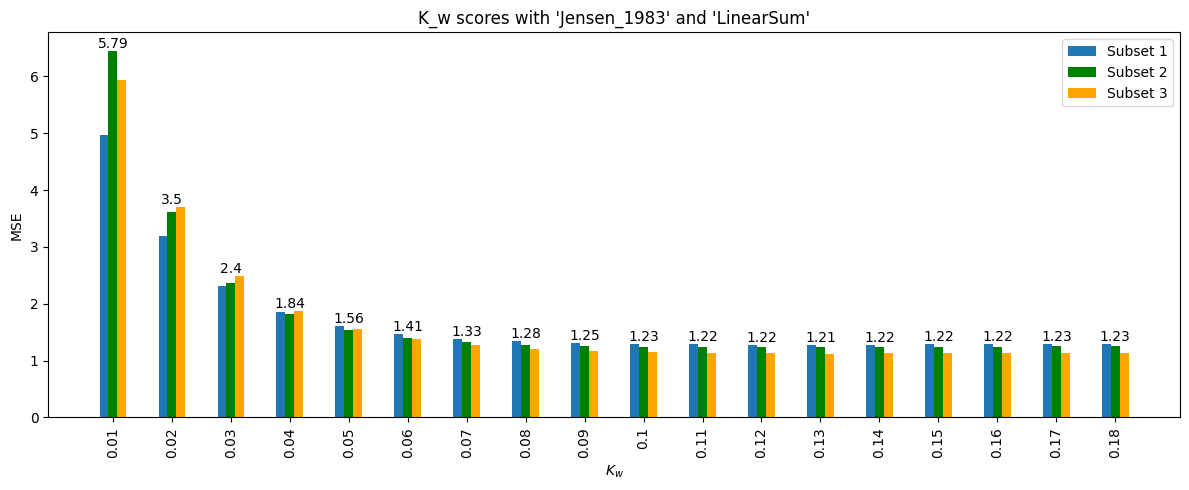

In [ ]:
plt.rcParams["figure.figsize"] = (12, 5)
plot_scores('Jensen_1983', 'LinearSum')
plt.show()

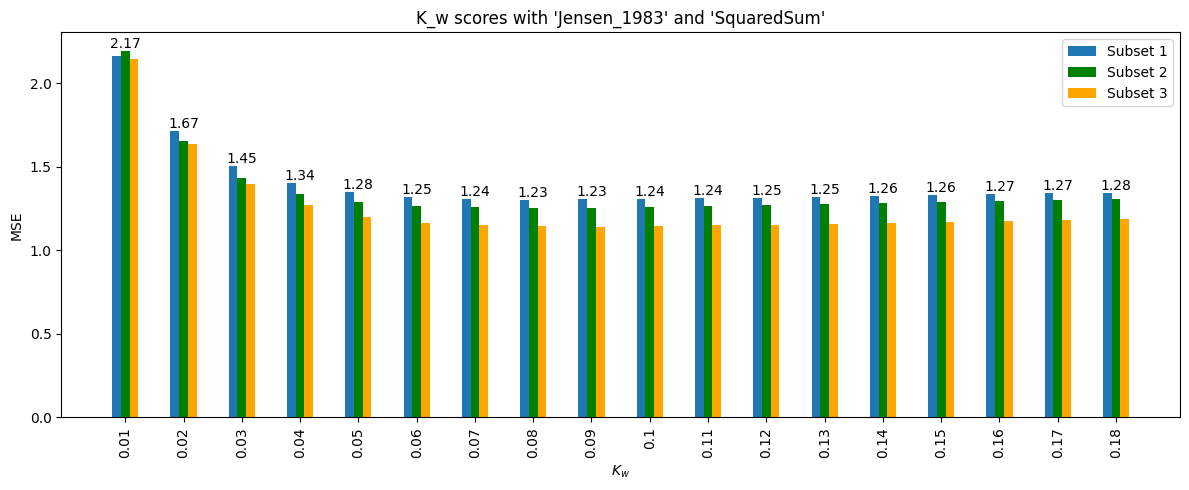

In [ ]:
plot_scores('Jensen_1983', 'SquaredSum')
plt.show()

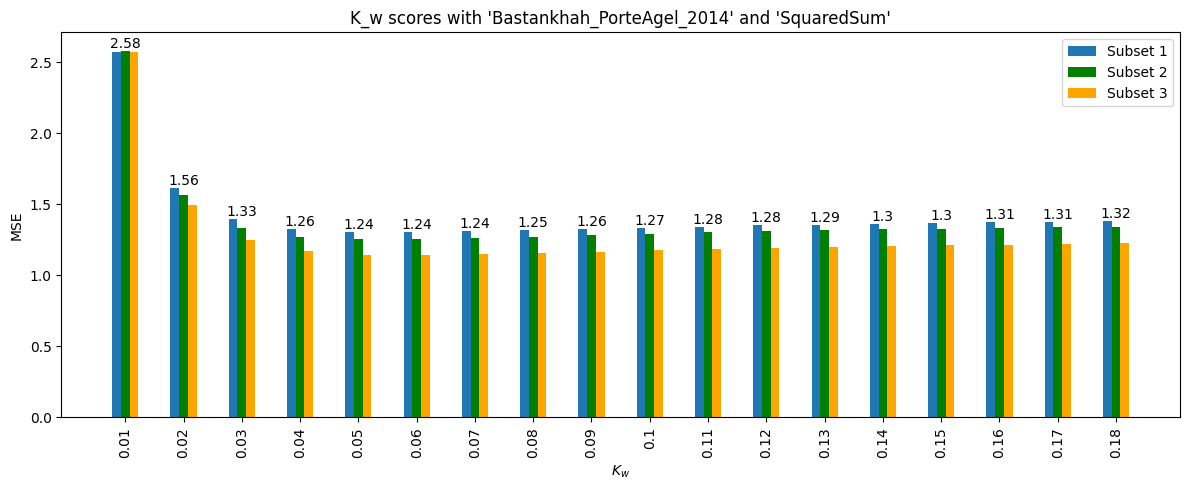

In [ ]:
plot_scores('Bastankhah_PorteAgel_2014', 'SquaredSum')
plt.show()

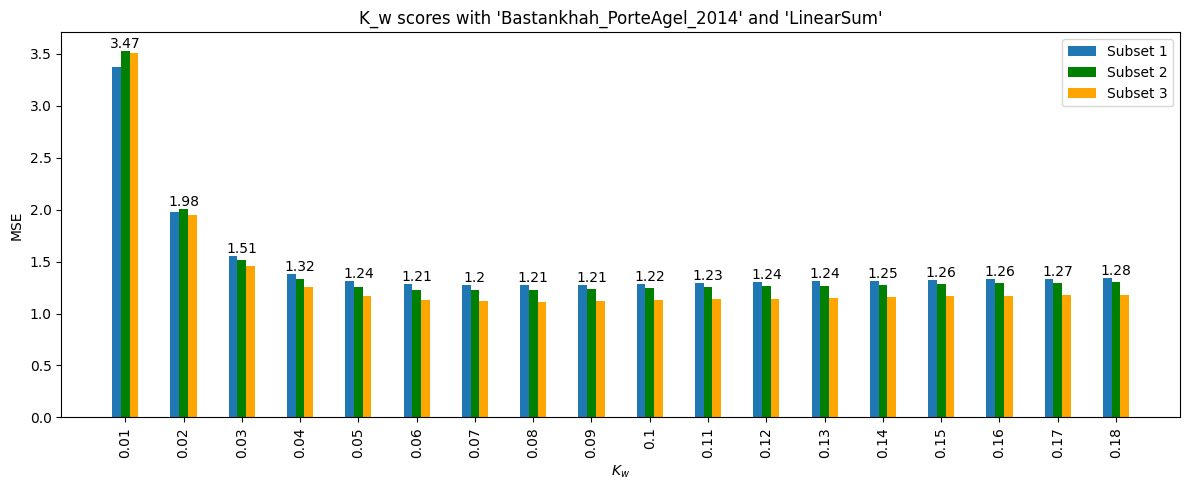

In [ ]:
plot_scores('Bastankhah_PorteAgel_2014', 'LinearSum')
plt.show()

## Testing additional approaches

### TI based K for Bahkstan, and linearSum

In [10]:
from wake_estimator import WakeEstimatorTI
ti_included_estimator_sq = WakeEstimatorTI(superpositionModel=SquaredSum)
ti_included_estimator_lin = WakeEstimatorTI(superpositionModel=LinearSum)

TI_wake_mse1_sq = objective_function(ti_included_estimator_sq, X_val=x_val_1, y_val=y_val_1)
TI_wake_mse1_lin = objective_function(ti_included_estimator_lin, X_val=x_val_1, y_val=y_val_1)

TI_wake_mse2_sq = objective_function(ti_included_estimator_sq, X_val=x_val_2, y_val=y_val_2)
TI_wake_mse2_lin = objective_function(ti_included_estimator_lin, X_val=x_val_2, y_val=y_val_2)

TI_wake_mse3_sq = objective_function(ti_included_estimator_sq, X_val=x_val_3, y_val=y_val_3)
TI_wake_mse3_lin = objective_function(ti_included_estimator_lin, X_val=x_val_3, y_val=y_val_3)

### No wake

In [11]:
nowake_pred1 = np.repeat(x_val_1[:, 0], y_val_1.shape[1]).reshape(y_val_1.shape)     
nowake_pred2 = np.repeat(x_val_2[:, 0], y_val_2.shape[1]).reshape(y_val_2.shape) 
nowake_pred3 = np.repeat(x_val_3[:, 0], y_val_3.shape[1]).reshape(y_val_3.shape) 

no_wake_mse1 = get_mse(nowake_pred1, y_val_1)
no_wake_mse2 = get_mse(nowake_pred2, y_val_2)
no_wake_mse3 = get_mse(nowake_pred3, y_val_3)

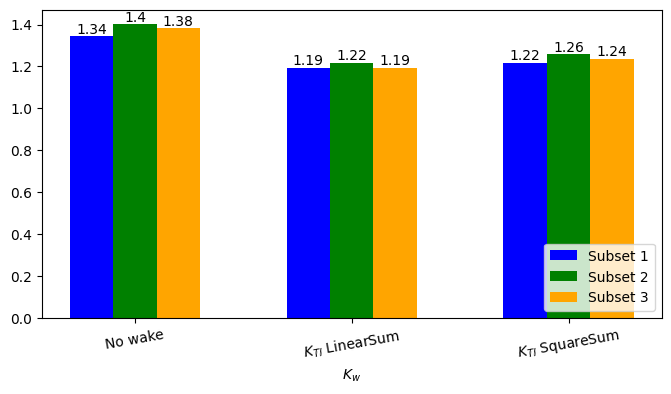

In [22]:
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams["figure.figsize"] = (8, 4)

nowake_bars = plt.bar(x=[0, 0.2, 0.4],height=[no_wake_mse1, no_wake_mse2, no_wake_mse3], width=0.2, color=['blue', 'green', 'orange'], label=['Subset 1', 'Subset 2', 'Subset 3'])
TI_k_bars_lin = plt.bar(x=[1, 1.2, 1.4],height=[TI_wake_mse1_lin, TI_wake_mse2_lin, TI_wake_mse3_lin], width=0.2, color=['blue', 'green', 'orange'])
TI_k_bars_sq = plt.bar(x=[2, 2.2, 2.4],height=[TI_wake_mse1_sq, TI_wake_mse2_sq, TI_wake_mse3_sq], width=0.2, color=['blue', 'green', 'orange'])

for bar in nowake_bars:
        yvalue = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{round(yvalue, 2)}', ha='center', va='bottom')
for bar in TI_k_bars_lin:
        yvalue = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{round(yvalue, 2)}', ha='center', va='bottom')
for bar in TI_k_bars_sq:
        yvalue = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2.0, bar.get_height(), f'{round(yvalue, 2)}', ha='center', va='bottom')

plt.xticks(np.array([0, 1, 2]) + 0.2, ['No wake', '$K_{TI}$ LinearSum', '$K_{TI}$ SquareSum'])
plt.legend(loc=4)
plt.xlabel('$K_w$')
plt.show()